In [1]:
import itertools
import os
import json
import copy
import sys
from collections import defaultdict
import itertools
import pandas as pd
from tqdm.notebook import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import linear_model
import seaborn as sns
import random
import seaborn as sns
import scipy.stats as stats
import pandas as pd
#import seaborn as sns
import seaborn as sns
from matplotlib import rcParams
import scipy
from scipy import stats
import seaborn as sns
from scipy import stats
import sys
import seaborn as sns
from utils import *
import numpy as np
pd.set_option('display.max_rows', 500)

In [2]:
# MLQE

In [3]:
AVAILBLE_DATASETS = ['DIALOG_pc.csv','DIALOG_tc.csv','FLICKR.csv','MLQE.csv','REAL_SUM.csv',
                     'SUM_EVAL.csv','TAC_08.csv','TAC_09.csv','TAC_11.csv']
data_path = 'final_df'
ds = 'DIALOG_tc.csv'

# Analysis by Systems 

### Build Borda Count

In [4]:
considered_df_system = pd.read_csv(os.path.join(data_path,ds)).set_index(['System','Utterance'])
assert considered_df_system.shape[0] % considered_df_system.loc[0].shape[0] == 0
nbs_system = considered_df_system.shape[0] // considered_df_system.loc[0].shape[0] 
nbs_utt = considered_df_system.loc[0].shape[0] 

In [5]:
considered_df_system

H:engaging  H:context  H:natural  H:overall  \
System Utterance                                                
0      M0           2.333333   1.000000   3.000000   3.333333   
       M1           2.666667   1.666667   2.333333   2.666667   
       M2           1.333333   1.333333   2.333333   2.000000   
       M3           2.333333   1.333333   3.000000   3.000000   
       M4           2.666667   2.666667   3.000000   4.666667   
1      M0           2.000000   2.666667   2.666667   3.666667   
       M1           1.666667   1.666667   2.333333   2.000000   
       M2           1.000000   1.000000   1.000000   1.000000   
       M3           1.666667   1.666667   2.333333   2.000000   
       M4           2.666667   2.666667   2.666667   3.666667   
2      M0           2.000000   2.333333   2.333333   3.333333   
       M1           1.666667   2.000000   1.666667   2.666667   
       M2           1.666667   2.000000   1.333333   2.000000   
       M3           2.000000   2.333333   2.333333   3.333333   
       M4           3.000000   3.000000   3.000000   5.000000   
3      M0           1.333333   1.333333   1.666667   1.666667   
       M1           1.333333   1.000000   2.333333   1.333333   
       M2           1.000000   1.666667   2.666667   1.666667   
       M3           1.333333   1.000000   2.000000   1.333333   
       M4           2.666667   3.000000   3.000000   5.000000   
4      M0           2.000000   2.333333   1.333333   2.666667   
       M1           2.333333   2.000000   2.666667   3.000000   
       M2           1.000000   1.333333   2.333333   1.666667   
       M3           1.000000   2.000000   1.666667   1.666667   
       M4           2.333333   3.000000   3.000000   4.333333   
5      M0           2.000000   1.333333   2.000000   1.666667   
       M1           1.666667   1.333333   1.666667   1.666667   
       M2           2.000000   1.666667   2.000000   1.666667   
       M3           1.000000   1.000000   1.000000   1.333333   
       M4           3.000000   3.000000   3.000000   5.000000   
6      M0           1.333333   1.333333   1.666667   1.333333   
       M1           1.000000   2.000000   2.333333   2.333333   
       M2           1.000000   1.000000   1.333333   1.000000   
       M3           1.000000   1.666667   2.333333   2.000000   
       M4           3.000000   3.000000   3.000000   5.000000   
7      M0           2.666667   3.000000   3.000000   3.666667   
       M1           1.000000   1.000000   1.333333   1.000000   
       M2           3.000000   3.000000   3.000000   5.000000   
       M3           2.333333   2.666667   2.000000   4.000000   
       M4           3.000000   2.666667   3.000000   4.666667   
8      M0           2.666667   2.333333   2.333333   3.666667   
       M1           3.000000   2.666667   3.000000   4.666667   
       M2           2.666667   2.333333   1.666667   3.000000   
       M3           2.000000   2.000000   1.666667   2.666667   
       M4           3.000000   3.000000   3.000000   5.000000   
9      M0           2.333333   2.000000   1.666667   3.000000   
       M1           2.333333   2.333333   2.333333   2.666667   
       M2           1.000000   1.000000   1.000000   1.000000   
       M3           1.333333   1.000000   1.000000   1.000000   
       M4           3.000000   3.000000   3.000000   5.000000   
10     M0           2.333333   3.000000   2.000000   3.333333   
       M1           1.666667   2.333333   1.333333   2.666667   
       M2           2.000000   2.333333   1.666667   2.666667   
       M3           1.333333   1.666667   1.333333   2.333333   
       M4           3.000000   3.000000   3.000000   5.000000   
11     M0           2.666667   3.000000   3.000000   4.666667   
       M1           1.333333   1.666667   2.000000   2.000000   
       M2           2.000000   2.000000   2.666667   3.333333   
       M3           1.333333   2.000000   2.666667   2.000000   
       M4           3.000000   3.000000   3.000000   

In [6]:
nbs_system,nbs_utt

(60, 5)

In [7]:
dic = {}

for column in list(considered_df_system.columns):
    print(column)
    dic['borda_{}'.format(column)] = []
    for i in range(nbs_system): 
        current_borda_count = np.argsort(np.argsort(considered_df_system.loc[i][column].values)).tolist()
        dic['borda_{}'.format(column)] += current_borda_count
dic['System'] = sum([['M{}'.format(i)]*nbs_utt for i in range(nbs_system)],[])
dic['Utt'] = sum([['U{}'.format(i) for i in range(nbs_utt)]* nbs_system],[])

H:engaging
H:context
H:natural
H:overall
H:understandable
H:useknowledge
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore


In [8]:
df_borda_system = pd.DataFrame(dic).set_index('System')
df_borda_system.head()
human_metric = [ i for i in df_borda_system.columns if ('H:' in i and 'Utt' not in i)]
other_metric = [ i for i in df_borda_system.columns if ('H:' not in i and 'Utt' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:engaging', 'borda_H:context', 'borda_H:natural', 'borda_H:overall', 'borda_H:understandable', 'borda_H:useknowledge']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


In [9]:
df_borda_system

,borda_H:engaging,borda_H:context,borda_H:natural,borda_H:overall,borda_H:understandable,borda_H:useknowledge,borda_S3_pyr,borda_S3_resp,borda_ROUGE_WE_1,borda_ROUGE_WE_2,borda_JS_1,borda_JS_2,borda_ROUGE_L,borda_ROUGE_1,borda_ROUGE_2,borda_BLEU,borda_Chrfpp,borda_BERTScore,borda_MoverScore,Utt
System,,,,,,,,,,,,,,,,,,,,
M0,1,0,2,3,2,0,2,1,4,1,2,2,2,2,0,1,2,2,3,U0
M0,3,3,0,1,0,1,3,3,3,2,4,3,3,3,1,4,4,3,2,U1
M0,0,1,1,0,3,2,0,0,0,0,0,0,0,0,2,0,0,0,0,U2
M0,2,2,3,2,1,3,4,4,1,4,3,4,4,4,4,3,3,4,4,U3
M0,4,4,4,4,4,4,1,2,2,3,1,1,1,1,3,2,1,1,1,U4
M1,3,3,3,3,2,0,2,2,0,2,2,4,1,0,3,2,1,4,4,U0
M1,1,1,1,1,3,1,3,3,3,1,3,0,4,3,1,1,0,3,0,U1
M1,0,0,0,0,0,2,0,1,1,0,1,2,2,1,2,3,3,1,3,U2
M1,2,2,2,2,1,3,1,0,2,3,0,1,0,2,0,0,2,0,2,U3


### Build training set

In [10]:
X_train = df_borda_system.values[:,:-1]

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
for n_com in range(16):
    pca = PCA(n_components=n_com)
    scaler = StandardScaler()
    pca.fit(scaler.fit_transform(X_train))
    print(pca.explained_variance_ratio_)

[]
[0.54176014]
[0.54176014 0.1696203 ]
[0.54176014 0.1696203  0.05332777]
[0.54176014 0.1696203  0.05332777 0.04094897]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225
 0.0218685 ]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225
 0.0218685  0.01949384]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225
 0.0218685  0.01949384 0.01597963]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225
 0.0218685  0.01949384 0.01597963 0.01511964]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225
 0.0218685  0.01949384 0.01597963 0.01511964 0.01258886]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225
 0.0218685  0.01949384 0.01597963 0.01511964 0.01258886 0.01163776]
[0.54176014 0.1696203  0.05332777 0.04094897 0.02655227 0.02390225
 0.0218685  0.01949384 0.01597963 0.015119

[0.54176014 0.1696203 ]
('M0', 'U4')
('M3', 'U2')
('M3', 'U4')
('M8', 'U4')
('M13', 'U2')
('M13', 'U4')
('M15', 'U4')
('M16', 'U2')
('M17', 'U4')
('M19', 'U2')
('M21', 'U4')
('M23', 'U3')
('M24', 'U4')
('M25', 'U4')
('M28', 'U4')
('M29', 'U3')
('M29', 'U4')
('M30', 'U4')
('M31', 'U4')
('M33', 'U3')
('M38', 'U3')
('M38', 'U4')
('M43', 'U4')
('M44', 'U4')
('M45', 'U4')
('M46', 'U4')
('M48', 'U1')
('M49', 'U4')
('M52', 'U4')
('M53', 'U2')
('M53', 'U4')
('M55', 'U3')
('M56', 'U1')
('M57', 'U4')
('M59', 'U4')


Text(0, 0.5, 'component 2')

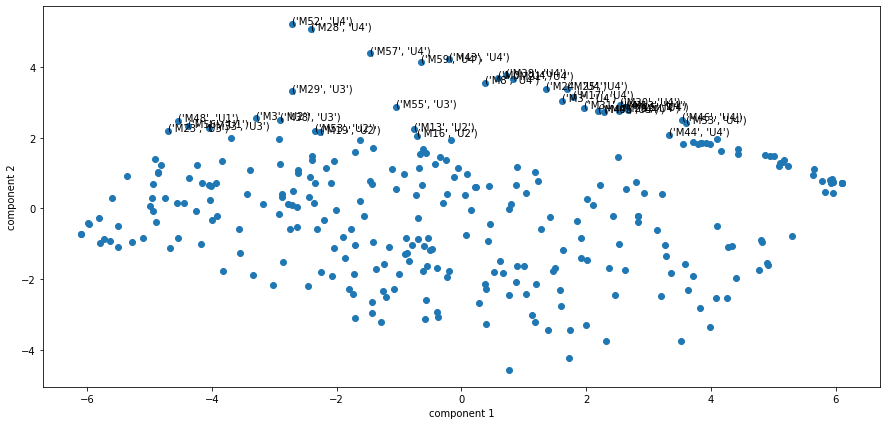

In [12]:
pca = PCA(n_components=2)
scaler = StandardScaler()
projected = pca.fit_transform(scaler.fit_transform(X_train))
print(pca.explained_variance_ratio_)
plt.figure(figsize=(15,7))
x = projected[:, 0].tolist()
y =  projected[:, 1].tolist()
plt.scatter(x,y)

for i, txt in enumerate(zip(list(df_borda_system.index),list(df_borda_system['Utt']))):
    if y[i] > 2:
        print(txt)
        plt.annotate(txt, (x[i], y[i]))

plt.xlabel('component 1')
plt.ylabel('component 2')

# Analysis by utterance 

In [13]:
considered_df_utterance = pd.read_csv(os.path.join(data_path,ds)).set_index(['Utterance','System'])
assert considered_df_utterance.shape[0] % considered_df_utterance.loc['M0'].shape[0] == 0
nbs_utt = considered_df_utterance.shape[0] // considered_df_utterance.loc['M0'].shape[0] 
nbs_system = considered_df_utterance.loc['M0'].shape[0] 

In [14]:
nbs_system,nbs_utt

(60, 5)

In [15]:
dic_utterance = {}

for column in list(considered_df_utterance.columns):
    print(column)
    dic_utterance['borda_{}'.format(column)] = []
    for i in range(nbs_utt): 
        current_borda_count = np.argsort(np.argsort(
            considered_df_utterance.loc['M{}'.format(i)][column].values)).tolist()
        dic_utterance['borda_{}'.format(column)] += current_borda_count

H:engaging
H:context
H:natural
H:overall
H:understandable
H:useknowledge
S3_pyr
S3_resp
ROUGE_WE_1
ROUGE_WE_2
JS_1
JS_2
ROUGE_L
ROUGE_1
ROUGE_2
BLEU
Chrfpp
BERTScore
MoverScore


In [16]:
dic_utterance['System'] = sum([['M{}'.format(i) for i in range(nbs_system)]*nbs_utt],[]) # TODO : pas sur
dic_utterance['Utt'] = sum([['U{}'.format(i)]* nbs_utt  for i in range(nbs_system)],[])
df_borda_utterance = pd.DataFrame(dic_utterance).set_index('Utt')

In [17]:
human_metric = [ i for i in df_borda_utterance.columns if ('H:' in i and 'System' not in i)]
other_metric = [ i for i in df_borda_utterance.columns if ('H:' not in i and 'System' not in i)]
print("Human", human_metric)
print("Other", other_metric)

Human ['borda_H:engaging', 'borda_H:context', 'borda_H:natural', 'borda_H:overall', 'borda_H:understandable', 'borda_H:useknowledge']
Other ['borda_S3_pyr', 'borda_S3_resp', 'borda_ROUGE_WE_1', 'borda_ROUGE_WE_2', 'borda_JS_1', 'borda_JS_2', 'borda_ROUGE_L', 'borda_ROUGE_1', 'borda_ROUGE_2', 'borda_BLEU', 'borda_Chrfpp', 'borda_BERTScore', 'borda_MoverScore']


In [18]:
X_train_utterance = df_borda_utterance.values[:,:-1]


[0.56181867 0.17312528]


Text(0, 0.5, 'component 2')

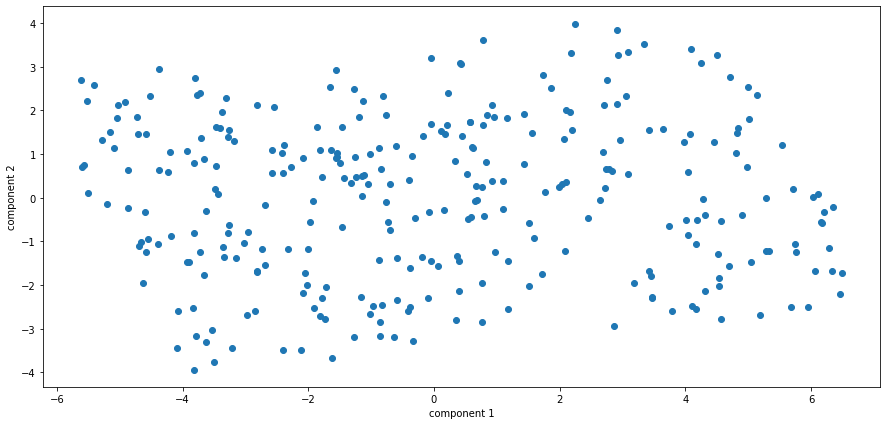

In [19]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(n_components=2)
scaler = StandardScaler()
projected = pca.fit_transform(scaler.fit_transform(X_train_utterance))
print(pca.explained_variance_ratio_)
plt.figure(figsize=(15,7))
x = projected[:, 0].tolist()
y =  projected[:, 1].tolist()
plt.scatter(x,y)

for i, txt in enumerate(zip(list(df_borda_system.index),list(df_borda_system['Utt']))):
    if x[i] < -6:
        print(txt)
        plt.annotate(txt, (x[i], y[i]))

plt.xlabel('component 1')
plt.ylabel('component 2')